## Portfolio Optimization

Use this code to execute a portfolio optimization model. This strategy will select the portfolio with the maximum Sharpe Ratio. The parameters are set to use 180 days of historical data and rebalance every 30 days. This code was used in writting the following article: [Markowitz Portfolio Optimization for Cryptocurrencies](https://medium.com/catalyst-crypto/markowitz-portfolio-optimization-for-cryptocurrencies-in-catalyst-b23c38652556).

Source code: [examples/portfolio_optimization.py](https://github.com/enigmampc/catalyst/blob/master/catalyst/examples/portfolio_optimization.py)

In [ ]:
# Register the catalyst magic
%load_ext catalyst

In [5]:
# Setup matplotlib to display graphs inline in this Notebook
%matplotlib inline

For the example below please $\color{red}{\text{ingest the data by running the following command}}$:

In [1]:
! catalyst ingest-exchange -x poloniex -f daily -i btc_usdt,eth_usdt,ltc_usdt,dash_usdt,xmr_usdt

fatal: not a git repository: /catalyst/../.git/modules/catalyst
Trying to ingest exchange bundle poloniex...
    [====================================]  Ingesting daily price data on poloniex:  100%             


Running in backtesting mode.


[2019-02-19 12:42:41.246423] INFO: run_algo: Catalyst version 0+unknown
[2019-02-19 12:42:41.247563] WARNING: run_algo: Catalyst is currently in ALPHA. It is going through rapid development and it is subject to errors. Please use carefully. We encourage you to report any issue on GitHub: https://github.com/enigmampc/catalyst/issues
[2019-02-19 12:42:44.250836] INFO: run_algo: running algo in backtest mode
[2019-02-19 12:42:44.691110] INFO: exchange_algorithm: initialized trading algorithm in backtest mode


r                                 2.033317
stdev                             0.542181
sharpe                            3.750258
TradingPair(374465 [btc_usdt])    0.336895
TradingPair(23347 [eth_usdt])     0.006996
TradingPair(19201 [ltc_usdt])     0.005809
TradingPair(3314 [dash_usdt])     0.439090
TradingPair(748770 [xmr_usdt])    0.211210
Name: 15743, dtype: float64


r                                 2.065935
stdev                             0.604403
sharpe                            3.418144
TradingPair(374465 [btc_usdt])    0.145192
TradingPair(23347 [eth_usdt])     0.000957
TradingPair(19201 [ltc_usdt])     0.014950
TradingPair(3314 [dash_usdt])     0.634026
TradingPair(748770 [xmr_usdt])    0.204875
Name: 28439, dtype: float64


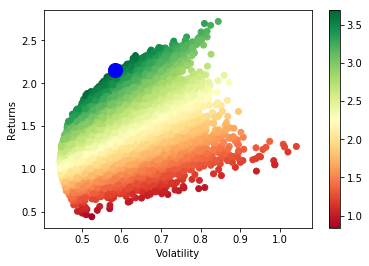

r                                 2.154484
stdev                             0.583798
sharpe                            3.690464
TradingPair(374465 [btc_usdt])    0.399902
TradingPair(23347 [eth_usdt])     0.024946
TradingPair(19201 [ltc_usdt])     0.016789
TradingPair(3314 [dash_usdt])     0.551632
TradingPair(748770 [xmr_usdt])    0.006731
Name: 15752, dtype: float64


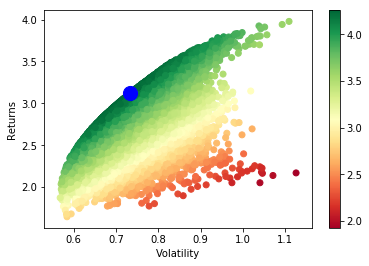

r                                 3.117974
stdev                             0.732418
sharpe                            4.257099
TradingPair(374465 [btc_usdt])    0.355688
TradingPair(23347 [eth_usdt])     0.164040
TradingPair(19201 [ltc_usdt])     0.259902
TradingPair(3314 [dash_usdt])     0.155074
TradingPair(748770 [xmr_usdt])    0.065296
Name: 38408, dtype: float64


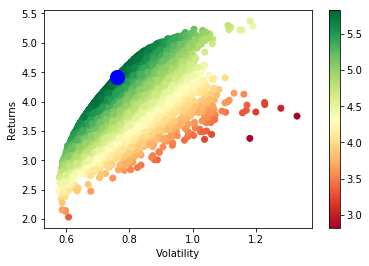

r                                 4.418110
stdev                             0.759242
sharpe                            5.819104
TradingPair(374465 [btc_usdt])    0.286139
TradingPair(23347 [eth_usdt])     0.172663
TradingPair(19201 [ltc_usdt])     0.258043
TradingPair(3314 [dash_usdt])     0.105400
TradingPair(748770 [xmr_usdt])    0.177754
Name: 34040, dtype: float64


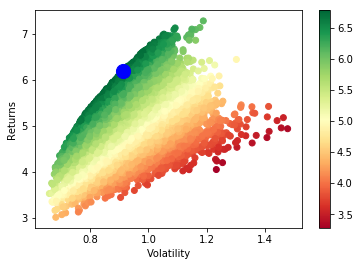

r                                 6.180150
stdev                             0.911408
sharpe                            6.780878
TradingPair(374465 [btc_usdt])    0.248334
TradingPair(23347 [eth_usdt])     0.154807
TradingPair(19201 [ltc_usdt])     0.440453
TradingPair(3314 [dash_usdt])     0.152128
TradingPair(748770 [xmr_usdt])    0.004278
Name: 11551, dtype: float64


In [ ]:
%%catalyst --start 2017-1-1 --end 2017-8-16 --capital-base 100000 -x poloniex -c usdt


'''Use this code to execute a portfolio optimization model. This code
   will select the portfolio with the maximum Sharpe Ratio. The parameters
   are set to use 180 days of historical data and rebalance every 30 days.

   This is the code used in the following article:
   https://blog.enigma.co/markowitz-portfolio-optimization-for-cryptocurrencies-in-catalyst-b23c38652556

   You can run this code using the Python interpreter:

   $ python portfolio_optimization.py
'''

from __future__ import division
import os
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from catalyst.api import record, symbols, order_target_percent
from catalyst.utils.run_algo import run_algorithm

np.set_printoptions(threshold=np.nan, suppress=True)


def initialize(context):
    # Portfolio assets list
    context.assets = symbols('btc_usdt', 'eth_usdt', 'ltc_usdt', 'dash_usdt',
                             'xmr_usdt')
    context.nassets = len(context.assets)
    # Set the time window that will be used to compute expected return
    # and asset correlations
    context.window = 180
    # Set the number of days between each portfolio rebalancing
    context.rebalance_period = 30
    context.i = 0


def handle_data(context, data):
    # Only rebalance at the beginning of the algorithm execution and
    # every multiple of the rebalance period
    if context.i == 0 or context.i % context.rebalance_period == 0:
        n = context.window
        prices = data.history(context.assets, fields='price',
                              bar_count=n + 1, frequency='1d')
        pr = np.asmatrix(prices)
        t_prices = prices.iloc[1:n + 1]
        t_val = t_prices.values
        tminus_prices = prices.iloc[0:n]
        tminus_val = tminus_prices.values
        # Compute daily returns (r)
        r = np.asmatrix(t_val / tminus_val - 1)
        # Compute the expected returns of each asset with the average
        # daily return for the selected time window
        m = np.asmatrix(np.mean(r, axis=0))
        # ###
        stds = np.std(r, axis=0)
        # Compute excess returns matrix (xr)
        xr = r - m
        # Matrix algebra to get variance-covariance matrix
        cov_m = np.dot(np.transpose(xr), xr) / n
        # Compute asset correlation matrix (informative only)
        corr_m = cov_m / np.dot(np.transpose(stds), stds)

        # Define portfolio optimization parameters
        n_portfolios = 50000
        results_array = np.zeros((3 + context.nassets, n_portfolios))
        for p in range(n_portfolios):
            weights = np.random.random(context.nassets)
            weights /= np.sum(weights)
            w = np.asmatrix(weights)
            p_r = np.sum(np.dot(w, np.transpose(m))) * 365
            p_std = np.sqrt(np.dot(np.dot(w, cov_m),
                                   np.transpose(w))) * np.sqrt(365)

            # store results in results array
            results_array[0, p] = p_r
            results_array[1, p] = p_std
            # store Sharpe Ratio (return / volatility) - risk free rate element
            # excluded for simplicity
            results_array[2, p] = results_array[0, p] / results_array[1, p]

            for i, w in enumerate(weights):
                results_array[3 + i, p] = w

        columns = ['r', 'stdev', 'sharpe'] + context.assets

        # convert results array to Pandas DataFrame
        results_frame = pd.DataFrame(np.transpose(results_array),
                                     columns=columns)
        # locate position of portfolio with highest Sharpe Ratio
        max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
        # locate positon of portfolio with minimum standard deviation
        # min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

        # order optimal weights for each asset
        for asset in context.assets:
            if data.can_trade(asset):
                order_target_percent(asset, max_sharpe_port[asset])

        # create scatter plot coloured by Sharpe Ratio
        plt.scatter(results_frame.stdev,
                    results_frame.r,
                    c=results_frame.sharpe,
                    cmap='RdYlGn')
        plt.xlabel('Volatility')
        plt.ylabel('Returns')
        plt.colorbar()

        # plot blue circle to highlight position of portfolio
        # with highest Sharpe Ratio
        plt.scatter(max_sharpe_port[1],
                    max_sharpe_port[0],
                    marker='o',
                    color='b',
                    s=200)

        plt.show()
        print(max_sharpe_port)
        record(pr=pr,
               r=r,
               m=m,
               stds=stds,
               max_sharpe_port=max_sharpe_port,
               corr_m=corr_m)
    context.i += 1


def analyze(context=None, results=None):
    # Form DataFrame with selected data
    data = results[['pr', 'r', 'm', 'stds', 'max_sharpe_port', 'corr_m',
                    'portfolio_value']]

    # Save results in CSV file
    filename = 'Markowitz'
    data.to_csv(filename + '.csv')